#### Importamos las librerías

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Almacenamos nuestra tabla en un Dataframe

In [302]:
# Importamos el dataframe con la columna "deposit" incluida
df_bank = pd.read_csv("perfil_cliente_mysql.csv", delimiter=";")

# Creamos un segundo dataframe sin la columna "deposit" para el algoritmo
df_kmeans = df_bank.drop(columns=["deposit"])

In [303]:
df_kmeans

,age,job,marital,education,balance,housing
0,59,admin,married,secondary,2343,yes
1,59,admin,married,secondary,2343,yes
2,56,admin,married,secondary,45,no
3,41,technician,married,secondary,1270,yes
4,55,services,married,secondary,2476,yes
...,...,...,...,...,...,...
15453,26,admin,married,secondary,1595,no
15454,37,admin,married,secondary,1967,no
15455,45,management,married,tertiary,81,no
15456,44,services,single,secondary,618,no


#### Vamos a convertir las categorías de trabajo en 3 subgrupos: Profesional, Manual y Otro

In [304]:
job_mapping = {
    "admin": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "retired": "otro",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_kmeans['job'] = df_kmeans['job'].replace(job_mapping)

print(df_kmeans['job'].value_counts())

job
profesional    9087
manual         4341
otro           2030
Name: count, dtype: int64


#### Y vamos a traducir el resto de categorías para que figuren en español

In [305]:
df_kmeans["marital"] = np.where(df_kmeans["marital"] == "married", "casado",
                                np.where(df_kmeans["marital"] == "single", "soltero",
                                         "divorciado"))

df_kmeans["education"] = np.where(df_kmeans["education"] == "primary", "primaria",
                                np.where(df_kmeans["education"] == "secondary", "secundaria",
                                         "terciaria"))

df_kmeans["housing"] = np.where(df_kmeans["housing"] == "no", "no", "sí")

df_kmeans

,age,job,marital,education,balance,housing
0,59,profesional,casado,secundaria,2343,sí
1,59,profesional,casado,secundaria,2343,sí
2,56,profesional,casado,secundaria,45,no
3,41,profesional,casado,secundaria,1270,sí
4,55,manual,casado,secundaria,2476,sí
...,...,...,...,...,...,...
15453,26,profesional,casado,secundaria,1595,no
15454,37,profesional,casado,secundaria,1967,no
15455,45,profesional,casado,terciaria,81,no
15456,44,manual,soltero,secundaria,618,no


#### Preprocesamiento variables categóricas

In [306]:
categorical_features = ["job", "marital", "education", "housing"]

label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    
    df_kmeans[feature + "_encoded"] = label_encoders[feature].fit_transform(df_kmeans[feature])

df_kmeans = df_kmeans.drop(columns=categorical_features, axis=1)

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,housing_encoded
0,59,2343,2,0,1,1
1,59,2343,2,0,1,1
2,56,45,2,0,1,0
3,41,1270,2,0,1,1
4,55,2476,0,0,1,1
...,...,...,...,...,...,...
15453,26,1595,2,0,1,0
15454,37,1967,2,0,1,0
15455,45,81,2,0,2,0
15456,44,618,0,2,1,0


#### Preprocesamiento variables numéricas

<Figure size 800x500 with 0 Axes>

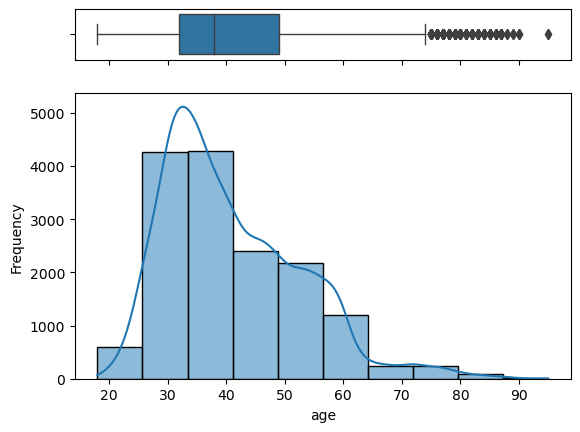

<Figure size 800x500 with 0 Axes>

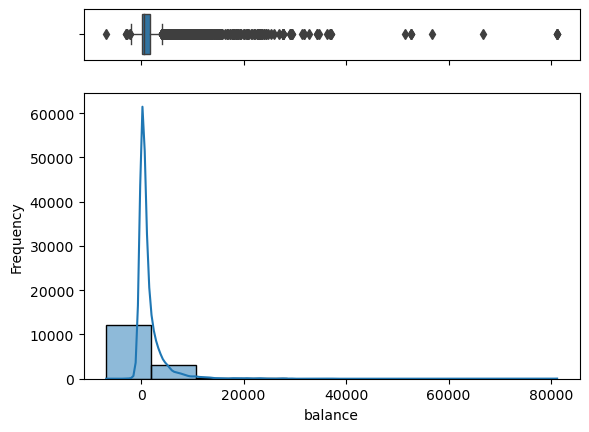

In [307]:
numerical_features = ["age", "balance"]

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    

    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Como las variables tienen outliers, vamos a utilizar los límites superiores e inferiores del IQR para reemplazarlos.

In [308]:
def percentile_calculation(df, column):
    percentile_75 = df[column].quantile(0.75)
    percentile_25 = df[column].quantile(0.25)
    IQR = percentile_75 - percentile_25
    upper_limit = percentile_75 + (1.5 * IQR)
    lower_limit = percentile_25 - (1.5 * IQR)
    return upper_limit, lower_limit

def winsorize_percentile(df, column):
    upper_limit, lower_limit = percentile_calculation(df, column)

    print(f'upper limit de {column}: {upper_limit}')
    print(f'lower limit de {column}: {lower_limit}')
    
    df[column] = np.where(df[column] > upper_limit, upper_limit,
                          np.where(df[column] < lower_limit, lower_limit, df[column]))
    return df


for i in numerical_features:
    df_kmeans = winsorize_percentile(df_kmeans, i)


upper limit de age: 74.5
lower limit de age: 6.5
upper limit de balance: 4060.0
lower limit de balance: -2244.0


<Figure size 800x500 with 0 Axes>

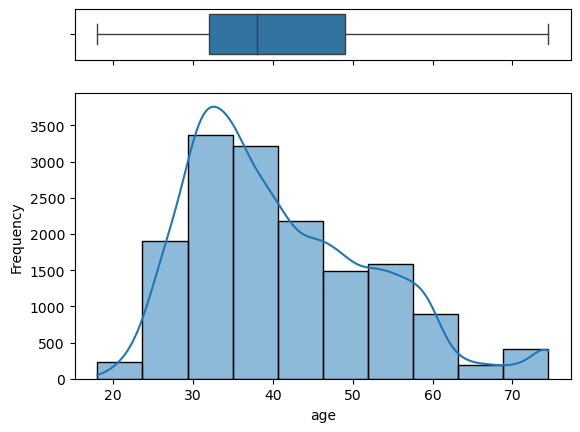

<Figure size 800x500 with 0 Axes>

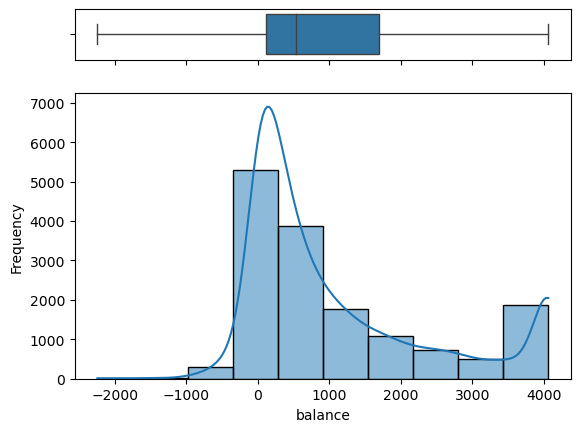

In [309]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df_kmeans[i], orient="h", ax=ax_box, linewidth=1.0)
    
    sns.histplot(df_kmeans[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Ahora que no tenemos outliers, estandarizamos las variables

In [310]:
scaler = StandardScaler()

df_kmeans[numerical_features] = scaler.fit_transform(df_kmeans[numerical_features])

df_kmeans

,age,balance,job_encoded,marital_encoded,education_encoded,housing_encoded
0,1.560119,0.918745,2,0,1,1
1,1.560119,0.918745,2,0,1,1
2,1.300211,-0.791836,2,0,1,0
3,0.000670,0.120027,2,0,1,1
4,1.213575,1.017747,0,0,1,1
...,...,...,...,...,...,...
15453,-1.298871,0.361950,2,0,1,0
15454,-0.345874,0.638859,2,0,1,0
15455,0.347214,-0.765038,2,0,2,0
15456,0.260578,-0.365307,0,2,1,0


#### Luego de estandarizar, veamos la distribución con media 0 y desviación estándar de 1.

<Figure size 800x500 with 0 Axes>

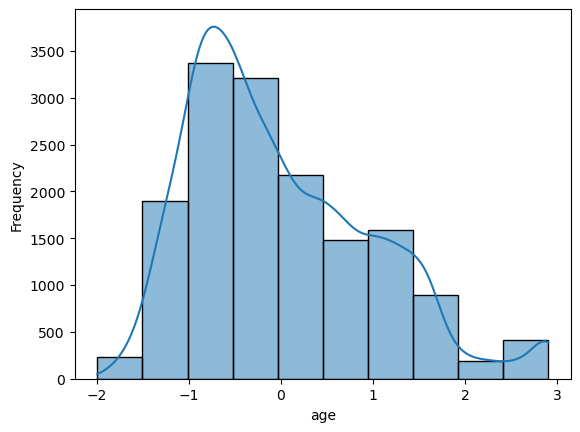

<Figure size 800x500 with 0 Axes>

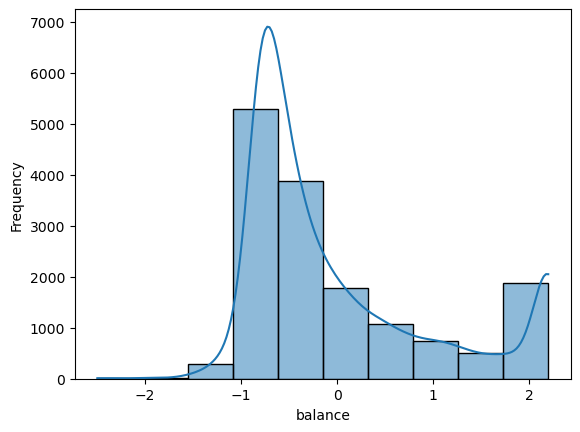

In [311]:
for i in numerical_features:
    plt.figure(figsize=(8, 5))
    
    f, ax = plt.subplots(sharex=True)

    sns.histplot(df_kmeans[i], bins=10, kde=True)
    
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

#### Identificamos el número de clusters

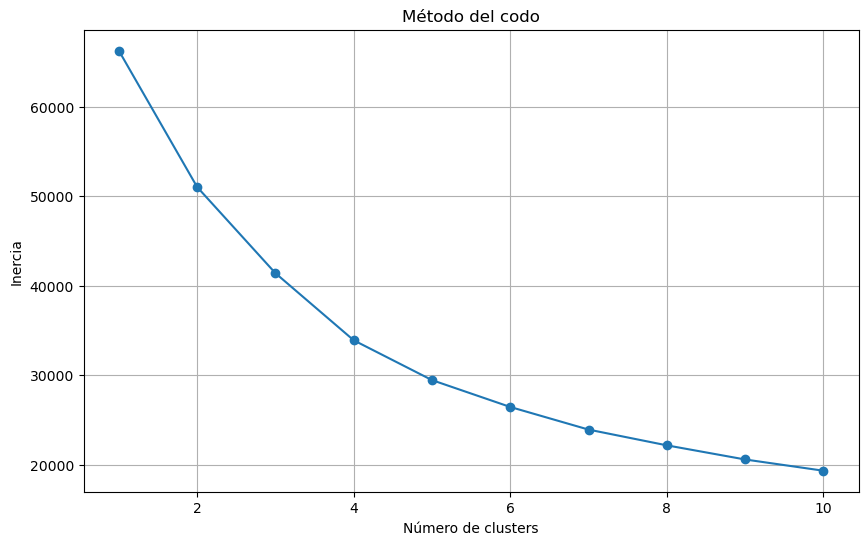

In [312]:
inertia = []

for k in range(1,11):

    kmeans = KMeans(n_clusters = k, 
                    init = "k-means++", 
                    max_iter = 300,
                    n_init = 10,
                    random_state = 42)

    kmeans.fit(df_kmeans)
    
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(range(1,11), inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

#### Ejecutamos el algoritmo de K-Means con 3 clusters

In [313]:
kmeans = KMeans(n_clusters = 3, 
                init="k-means++", 
                max_iter = 300, 
                n_init = 10, 
                random_state = 42)
           
df_kmeans['segmento'] = kmeans.fit_predict(df_kmeans)

In [314]:
score = silhouette_score(df_kmeans, df_kmeans['segmento'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.3501107679535038


In [315]:
# Recodificamos las variables categóricas
for feature in categorical_features:
    df_kmeans[feature + "_original"] = label_encoders[feature].inverse_transform(df_kmeans[feature + "_encoded"])
    df_kmeans = df_kmeans.drop(columns= feature + "_encoded")

# Para poder unificar con la tabla original, cambiamos el título de las columnas age y balance para que no estén duplicadas
df_kmeans = df_kmeans.rename(columns={"age": "age_kmeans", "balance": "balance_kmeans"})

# Y luego realizamos un join a través del índice

df_results = df_kmeans.join(df_bank).drop(columns=["job", "marital", "education", "housing"])

# Ahora cambiamos los nombres de los títulos a español

df_results = df_results.rename(columns={"age_kmeans": "edad_kmeans", 
                                        "job_original": "trabajo", 
                                        "marital_original": "estado civil", 
                                        "education_original": "educación",
                                        "housing_original": "hipoteca",
                                        "age": "edad",
                                        "deposit": "depósito"})

df_results["depósito"] = np.where(df_results["depósito"] == "no", "no", "sí")

df_results

,edad_kmeans,balance_kmeans,segmento,trabajo,estado civil,educación,hipoteca,edad,balance,depósito
0,1.560119,0.918745,1,profesional,casado,secundaria,sí,59,2343,sí
1,1.560119,0.918745,1,profesional,casado,secundaria,sí,59,2343,sí
2,1.300211,-0.791836,0,profesional,casado,secundaria,no,56,45,sí
3,0.000670,0.120027,0,profesional,casado,secundaria,sí,41,1270,sí
4,1.213575,1.017747,1,manual,casado,secundaria,sí,55,2476,sí
...,...,...,...,...,...,...,...,...,...,...
15453,-1.298871,0.361950,0,profesional,casado,secundaria,no,26,1595,sí
15454,-0.345874,0.638859,0,profesional,casado,secundaria,no,37,1967,sí
15455,0.347214,-0.765038,0,profesional,casado,terciaria,no,45,81,no
15456,0.260578,-0.365307,2,manual,soltero,secundaria,no,44,618,sí


In [316]:
df_results["segmento"].value_counts()

segmento
0    7924
2    4548
1    2986
Name: count, dtype: int64

#### Visualizamos los clusters creados en un mismo scatterplot

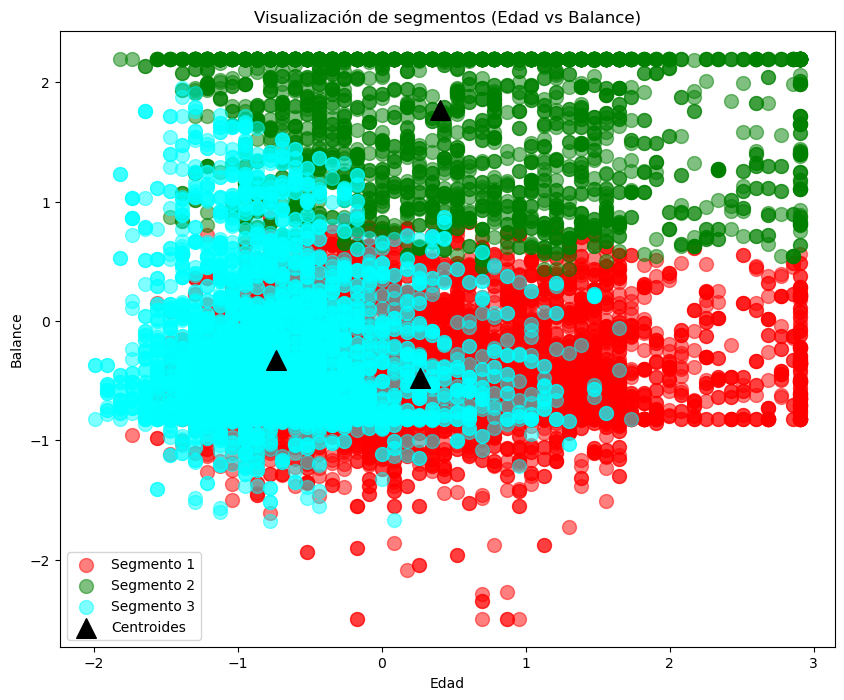

In [317]:
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'cyan']

for i in range(3):
    plt.scatter(df_results.loc[df_results['segmento'] == i, 'edad_kmeans'], 
                df_results.loc[df_results['segmento'] == i, 'balance_kmeans'], 
                s = 100, c = colors[i], label = f'Segmento {i + 1}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 200, c = 'black', marker='^', label='Centroides')

plt.title('Visualización de segmentos (Edad vs Balance)')
plt.xlabel('Edad')
plt.ylabel('Balance')
plt.legend()
plt.show()

#### Graficamos las variables numéricas

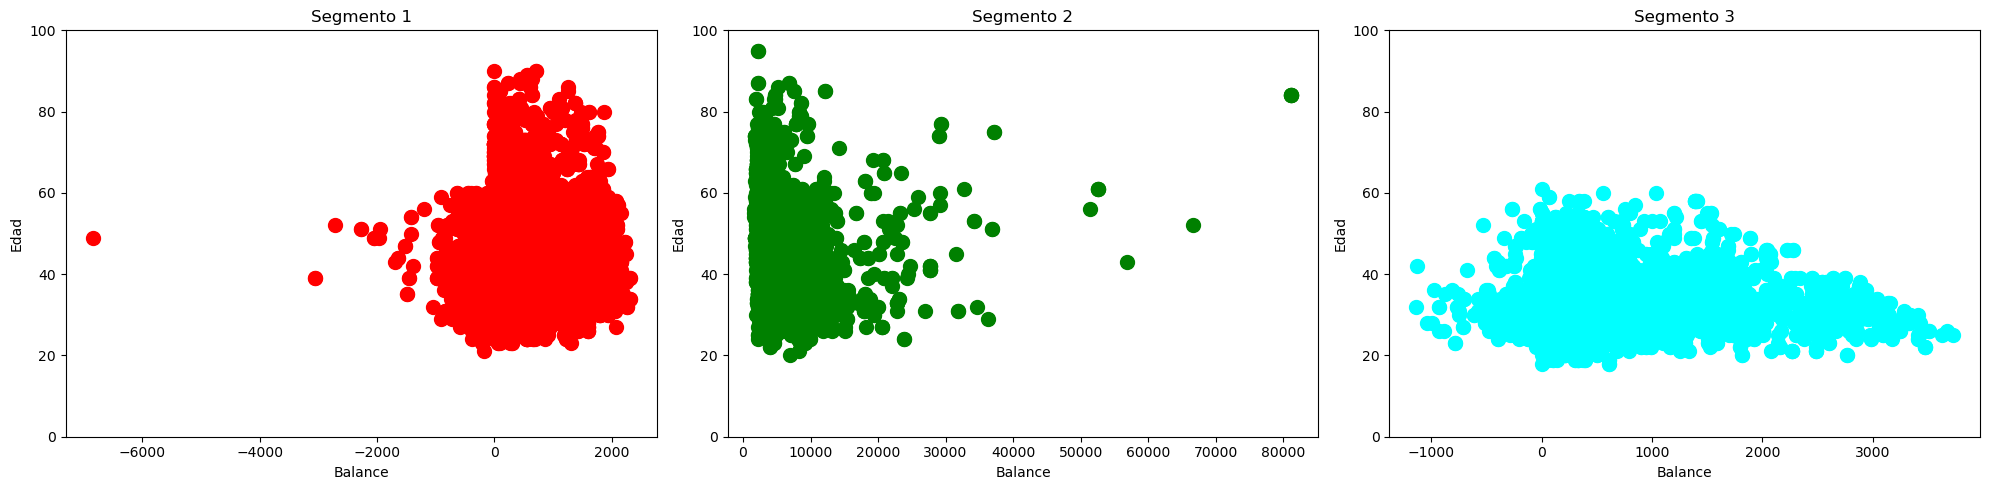

In [318]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

colors = ['red', 'green', 'cyan']

for i in range(3):
    axs[i].scatter(df_results.loc[df_results["segmento"] == i, "balance"], 
                   df_results.loc[df_results["segmento"] == i, "edad"], 
                   c = colors[i], s = 100)
    axs[i].set_title(f'Segmento {i + 1}')
    axs[i].set_xlabel('Balance') 
    axs[i].set_ylabel('Edad')
    axs[i].set_ylim([0, 100])

plt.tight_layout()
plt.show()

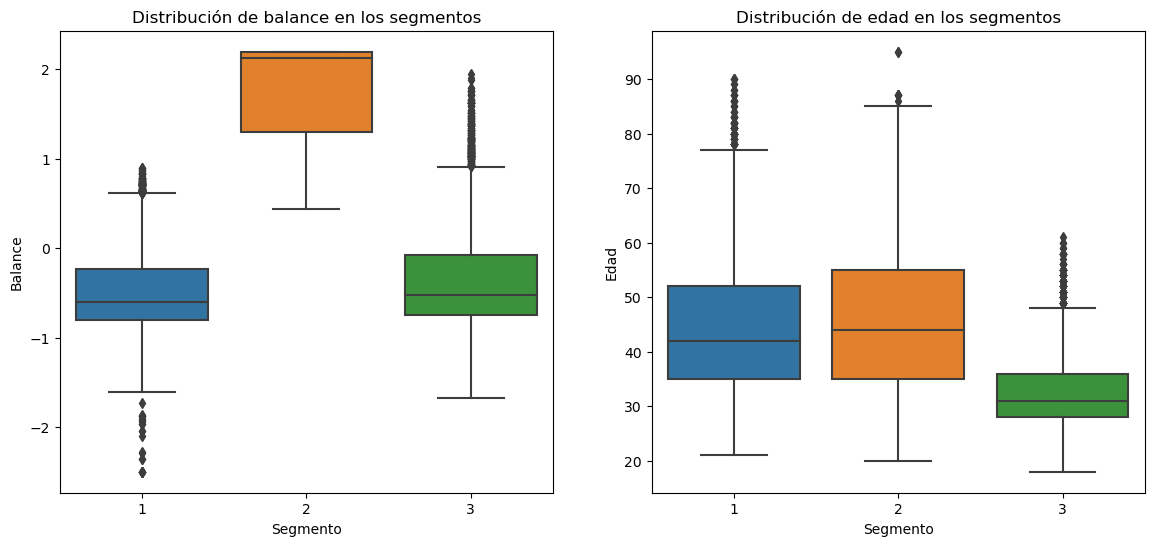

In [319]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='segmento', y='balance_kmeans', data=df_results)
plt.title('Distribución de balance en los segmentos')
plt.xlabel("Segmento")
plt.ylabel("Balance")
plt.xticks([0, 1, 2], ['1', '2', '3'])

plt.subplot(1, 2, 2)
sns.boxplot(x='segmento', y='edad', data=df_results)
plt.title('Distribución de edad en los segmentos')
plt.xlabel("Segmento")
plt.ylabel("Edad")
plt.xticks([0, 1, 2], ['1', '2', '3'])
plt.show()

#### Graficamos las variables categóricas

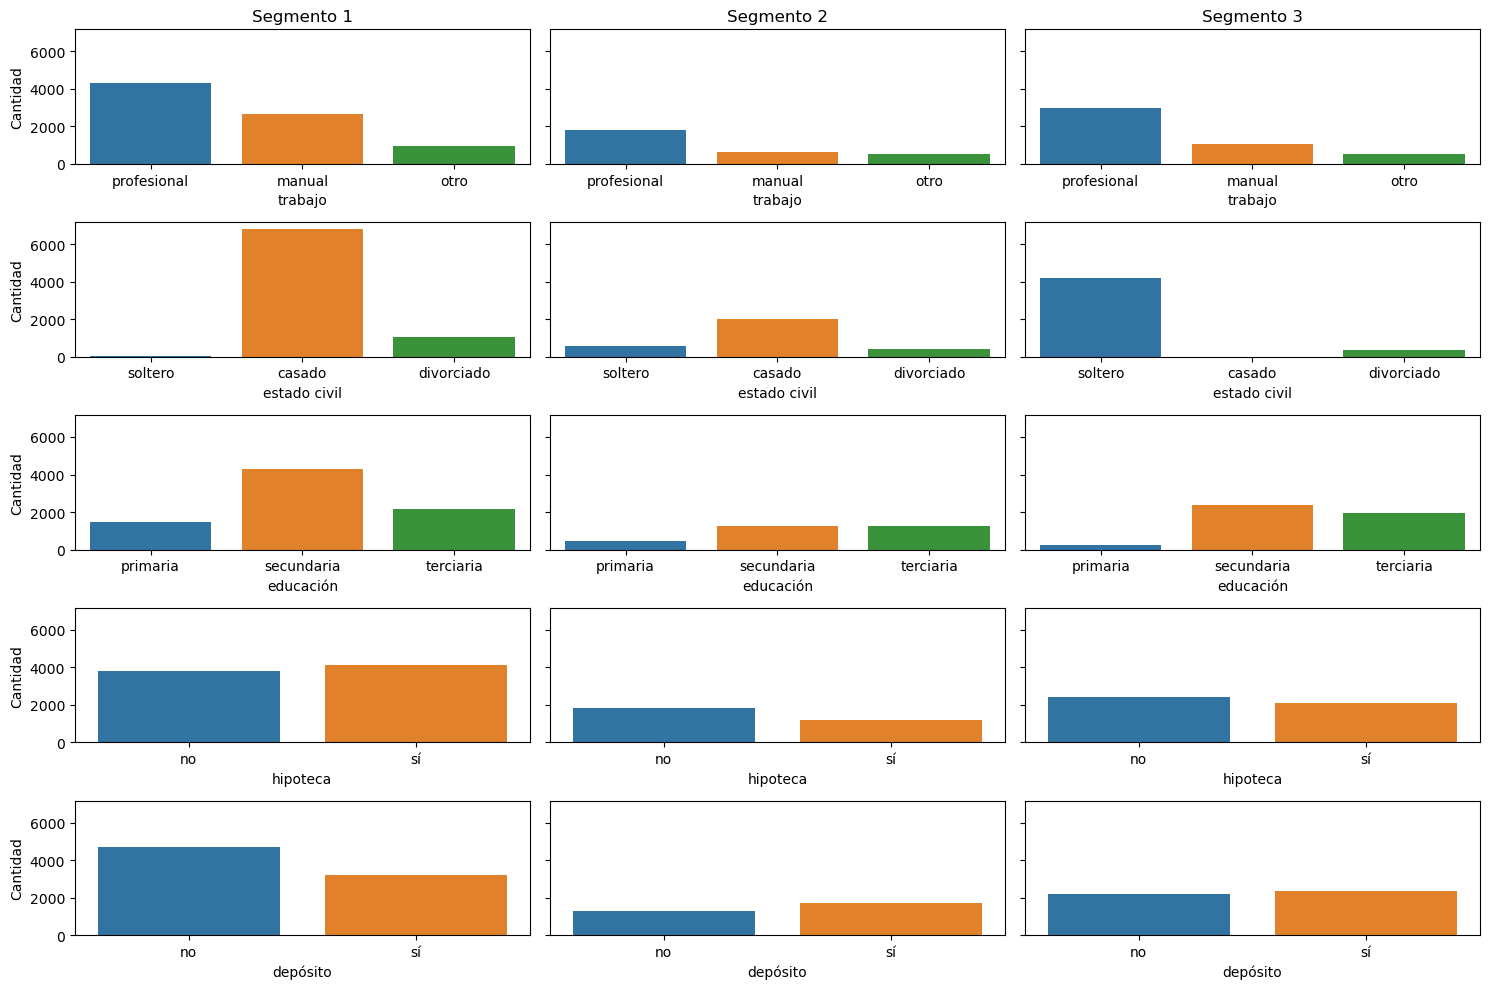

In [320]:
categorical_features = ["trabajo","estado civil","educación", "hipoteca", "depósito"]

clusters = sorted(df_results["segmento"].unique())

fig, axes = plt.subplots(nrows=len(categorical_features), ncols=len(clusters), figsize=(15, 10), sharey=True)

category_orders = {
    "trabajo": ["profesional", "manual", "otro"],
    "estado civil": ["soltero", "casado", "divorciado"],
    "educación": ['primaria', 'secundaria', 'terciaria'],
    'hipoteca': ['no', 'sí'],
    'depósito': ["no", "sí"]
}

for row, feature in enumerate(categorical_features):
    for col, cluster in enumerate(clusters):
        cluster_data = df_results[df_results['segmento'] == cluster]
        
        sns.countplot(data=cluster_data, x=feature, ax=axes[row, col], order=category_orders[feature])
        
        if row == 0:
            axes[row, col].set_title(f'Segmento {cluster + 1}')

        if col == 0:
            axes[row, col].set_ylabel("Cantidad")

        if col > 0:
            axes[row, col].set_ylabel(None)

        axes[row, col].set_xlabel(feature)


plt.tight_layout()
plt.show()

In [322]:
df_results["segmento"] = df_results["segmento"] + 1

df_results

,edad_kmeans,balance_kmeans,segmento,trabajo,estado civil,educación,hipoteca,edad,balance,depósito
0,1.560119,0.918745,2,profesional,casado,secundaria,sí,59,2343,sí
1,1.560119,0.918745,2,profesional,casado,secundaria,sí,59,2343,sí
2,1.300211,-0.791836,1,profesional,casado,secundaria,no,56,45,sí
3,0.000670,0.120027,1,profesional,casado,secundaria,sí,41,1270,sí
4,1.213575,1.017747,2,manual,casado,secundaria,sí,55,2476,sí
...,...,...,...,...,...,...,...,...,...,...
15453,-1.298871,0.361950,1,profesional,casado,secundaria,no,26,1595,sí
15454,-0.345874,0.638859,1,profesional,casado,secundaria,no,37,1967,sí
15455,0.347214,-0.765038,1,profesional,casado,terciaria,no,45,81,no
15456,0.260578,-0.365307,3,manual,soltero,secundaria,no,44,618,sí


In [323]:
df_results.to_csv("C:/Users/damim/Desktop/Projects/Kmeans_results_Tableau.csv")